# Формирование датасета

In [1]:
!gdown --id 1iysPjH-m0djpCHY-wKIo-kzjx9HsXfiP

Downloading...
From: https://drive.google.com/uc?id=1iysPjH-m0djpCHY-wKIo-kzjx9HsXfiP
To: /content/dataset.tar
100% 535M/535M [00:02<00:00, 189MB/s]


In [2]:
!tar -xf "/content/dataset.tar" -C "/"     #[run this cell to extract tar files]

In [3]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time
from PIL import Image
import matplotlib.pyplot as plt
import glob
import numpy as np
from IPython.display import clear_output
import time

class CTA_Dataset(Dataset):
    def __init__(self, root):
        self.root = root

        self.masks_path = sorted(glob.glob(root + '/*'))[::2]
        self.imgs_path = sorted(glob.glob(root + '/*'))[1::2]
    
    def __getitem__(self, idx):
        mask = np.asarray(Image.open(self.masks_path[idx]).convert('L'))
        image = np.asarray(Image.open(self.imgs_path[idx]).convert('L'))

        trans = transforms.Compose([transforms.ToTensor(),
                                    transforms.CenterCrop(288)
                                    ])
        mask = trans(mask)
        image = trans(image)

        mask = TF.rotate(mask, 270)
        image = TF.rotate(image, 270)

        return {'image': image,
                'mask': mask}

    def __len__(self):
        return len(self.imgs_path)

In [4]:
dataset = CTA_Dataset('/content/dataset')

In [5]:
print('Размер датасета', len(dataset))

Размер датасета 3754


# Обзор датасета

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:126: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


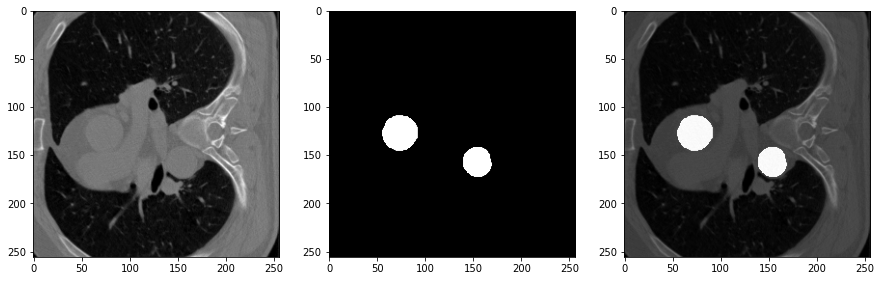

In [ ]:
data = dataset.__getitem__(1230)
image = data['image']
mask = data['mask']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
ax1.imshow(image[0], cmap='gray')
ax2.imshow(mask[0], cmap='gray')
ax3.imshow(image[0] + mask[0], cmap='gray')
plt.show()

In [ ]:
def first_nonzero(arr, axis, invalid_val=-1):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

In [ ]:
def f(arr, axis):
    return np.nonzero(arr)[axis].max()

In [ ]:
bot_pixel = -1
top_pixel = 512
left_pixel = 512
right_pixel = -1
for idx in range(len(dataset)):
    data = dataset.__getitem__(idx)
    mask = data['mask'][0].cpu().numpy()
    now_top = np.min(first_nonzero(mask, 0, 512))
    now_bot = f(mask, 0) + 1
    now_left = np.min(first_nonzero(mask, 1, 512))
    now_right = f(mask, 1) + 1
    if now_top < top_pixel:
        top_pixel = now_top
        save_idx_top = idx
    if now_bot > bot_pixel:
        bot_pixel = now_bot
        save_idx_bot = idx
    if now_left < left_pixel:
        left_pixel = now_left
        save_idx_left = idx
    if now_right > right_pixel:
        right_pixel = now_right
        save_idx_right = idx

print('Самый верхний ненулевой пиксель среди всех масок', top_pixel)
print('Достигается на изображении с индексом', save_idx_top)
print('Самый нижний ненулевой пиксель среди всех масок', bot_pixel)
print('Достигается на изображении с индексом', save_idx_bot)
print('Самый левый ненулевой пиксель среди всех масок', left_pixel)
print('Достигается на изображении с индексом', save_idx_left)
print('Самый правый ненулевой пиксель среди всех масок', right_pixel)
print('Достигается на изображении с индексом', save_idx_right)

Самый верхний ненулевой пиксель среди всех масок 156
Достигается на изображении с индексом 1398
Самый нижний ненулевой пиксель среди всех масок 400
Достигается на изображении с индексом 2765
Самый левый ненулевой пиксель среди всех масок 184
Достигается на изображении с индексом 1392
Самый правый ненулевой пиксель среди всех масок 318
Достигается на изображении с индексом 1767


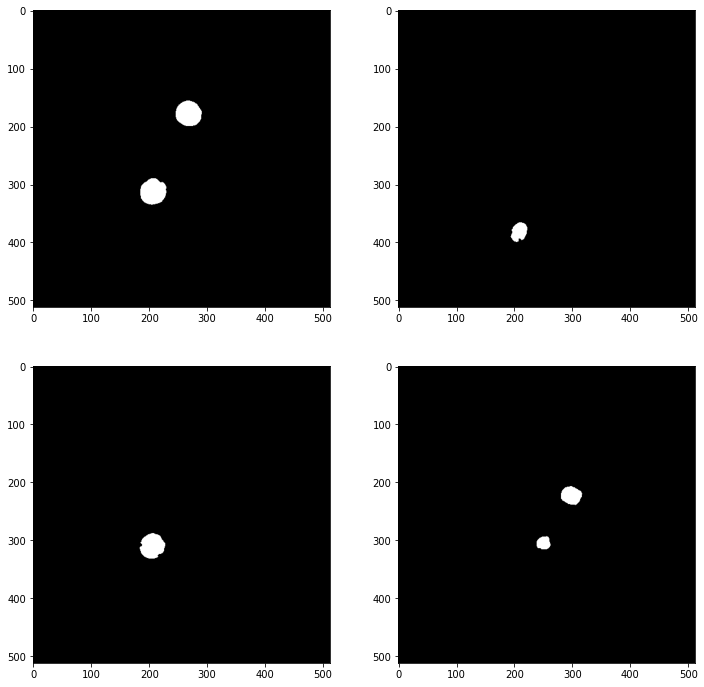

In [ ]:
data_top = dataset.__getitem__(save_idx_top)
image_top = data_top['image'][0]
mask_top = data_top['mask'][0]

data_bot = dataset.__getitem__(save_idx_bot)
image_bot = data_bot['image'][0]
mask_bot = data_bot['mask'][0]

data_left = dataset.__getitem__(save_idx_left)
image_left = data_left['image'][0]
mask_left = data_left['mask'][0]

data_right = dataset.__getitem__(save_idx_right)
image_right = data_right['image'][0]
mask_right = data_right['mask'][0]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
ax1.imshow(mask_top, cmap='gray')
ax2.imshow(mask_bot, cmap='gray')
ax3.imshow(mask_left, cmap='gray')
ax4.imshow(mask_right, cmap='gray')
# plt.figure(figsize=(4, 4))
# plt.imshow(mask_top, cmap='gray')
plt.show()

# Split, loss, train, score

In [6]:
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

data_loader_train = torch.utils.data.DataLoader(
 train_dataset, batch_size=25, shuffle=True)

data_loader_val = torch.utils.data.DataLoader(
 val_dataset, batch_size=20, shuffle=False)

In [7]:
def dice_loss(y_real, y_pred):
    y_pred = F.sigmoid(y_pred)
    num = torch.sum(2 * y_pred * y_real, (2,3))
    den =  torch.sum(y_pred + y_real, (2,3))
    res = 1 - (num + 1) / (den + 1)
    return res.mean()

In [8]:
device = 'cuda'
def train(model, opt, scheduler, loss_fn, epochs, data_tr, data_val, score=True):
    data = next(iter(data_val))
    X_val, Y_val = data['image'], data['mask']
    history_train_loss = []
    history_val_loss = []
    best_loss = np.inf
    best_metric = -1
    if score:
        history_metric = []

    start_time = time.time()
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        train_avg_loss, val_avg_loss = 0, 0
        model.train()  # train mode
        for data in data_tr:
            # data to device
            X_batch = data['image'].cuda()
            Y_batch = data['mask'].cuda()
            # set parameter gradients to zero
            opt.zero_grad()


            # forward
            Y_pred = model(X_batch) 

            loss = loss_fn(Y_batch, Y_pred) 
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            train_avg_loss += loss / len(data_tr) 

        scheduler.step()
        history_train_loss.append(train_avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).cpu().detach() # detach and put into cpu

        with torch.no_grad():
            for data in data_val:
                # data to device
                X_batch = data['image'].to(device)
                Y_batch = data['mask'].to(device)

                # forward
                Y_pred = model(X_batch) 

                loss = loss_fn(Y_batch, Y_pred) 

                val_avg_loss += loss / len(data_val)

            history_val_loss.append(val_avg_loss)
            metric = score_model(model, iou_pytorch, data_val)


            elapsed_time = time.time() - start_time
            loss_log = f'Train loss: {train_avg_loss:0.5f}, Elapsed_time: {elapsed_time:0.5f}'
            current_model_log = f'{"Current_metric":17s}: {metric:0.3f}, {"Current_loss":17s}: {val_avg_loss:0.2f}'

            if val_avg_loss < best_loss:
                best_loss = val_avg_loss
                torch.save(model.state_dict(), f'{epoch+1}_epoch_best_loss{best_loss:.4f}.pth')

            metric = score_model(model, iou_pytorch, data_val)
            if metric > best_metric:
                best_metric = metric
                torch.save(model.state_dict(), f'{epoch+1}_epoch_best_metric{best_metric:.4f}.pth')

            if score:
                history_metric.append(metric)

        best_model_log = f'{"Best_metric":17s}: {best_metric:0.3f}, {"Best_loss":17s}: {best_loss:0.2f}'
        loss_model_log = f'{loss_log}\n{current_model_log}\n{best_model_log}'
        
        print(loss_model_log)
        dashed_line = '-' * 80
        print(dashed_line)
    if score:
        return history_train_loss, history_val_loss, metric
    else:  
        return history_train_loss, history_val_loss

In [9]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  #

def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for d in data:
            X_batch = d['image']
            Y_label = d['mask']
            Y_pred = model(X_batch.cuda())
            scores += metric(Y_pred>0, Y_label.to(device)).mean().item()

    return scores/len(data)

# U-Net 1

In [24]:
class UNet(nn.Module): 
    def __init__(self):
        super().__init__()

        # encoder (downsampling)

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        self.pool0 = nn.MaxPool2d(kernel_size=2) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64 

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16 

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(
            in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(
            in_channels=512+256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear') # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(
            in_channels=256+128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear') # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(
            in_channels=128+64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear') # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(
            in_channels=64+32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=32, out_channels=1, kernel_size=3, padding=1)
            )



    def forward(self, x):
        # encoder
        e0_0 = self.enc_conv0(x)
        e0 = self.pool0(e0_0)
        e1_0 = self.enc_conv1(e0)
        e1 = self.pool1(e1_0)
        e2_0 = self.enc_conv2(e1)
        e2 = self.pool2(e2_0)
        e3_0 = self.enc_conv3(e2)
        e3 = self.pool3(e3_0)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat((d0, e3_0), dim=1)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0)
        d1 = torch.cat((d1, e2_0), dim=1)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        d2 = torch.cat((d2, e1_0), dim=1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2)
        d3 = torch.cat((d3, e0_0), dim=1)
        d3 = self.dec_conv3(d3)

        return d3


In [25]:
unet_model = UNet().to(device)
optimaizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
lr_scheduler_exp = lr_scheduler.StepLR(optimaizer, step_size=5, gamma=0.6)

In [ ]:
train_loss, val_loss, score = train(unet_model, optimaizer, lr_scheduler_exp, dice_loss, 20, data_loader_train, data_loader_val, score=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:126: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


* Epoch 1/20


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.54807, Elapsed_time: 300.52237
Current_metric   : 0.471, Current_loss     : 0.21
Best_metric      : 0.471, Best_loss        : 0.21
--------------------------------------------------------------------------------
* Epoch 2/20
Train loss: 0.16917, Elapsed_time: 641.67730
Current_metric   : 0.113, Current_loss     : 0.65
Best_metric      : 0.471, Best_loss        : 0.21
--------------------------------------------------------------------------------
* Epoch 3/20
Train loss: 0.12691, Elapsed_time: 982.78790
Current_metric   : 0.668, Current_loss     : 0.13
Best_metric      : 0.668, Best_loss        : 0.13
--------------------------------------------------------------------------------
* Epoch 4/20
Train loss: 0.10954, Elapsed_time: 1321.69180
Current_metric   : 0.662, Current_loss     : 0.14
Best_metric      : 0.668, Best_loss        : 0.13
--------------------------------------------------------------------------------
* Epoch 5/20
Train loss: 0.08844, Elapsed_time: 1660.572

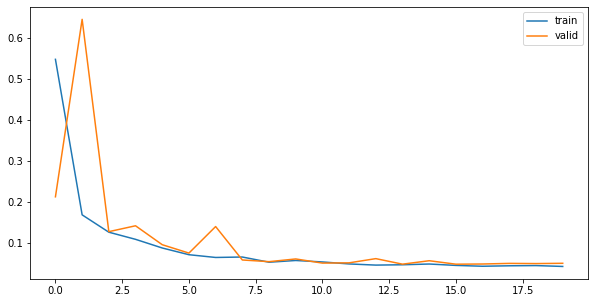

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='valid')
plt.legend()
plt.show()

In [27]:
data = next(iter(data_loader_val))
X_val, Y_val = data['image'], data['mask']
unet_model.eval()
with torch.no_grad():
    Y_hat = unet_model(X_val.to(device)).cpu().detach()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


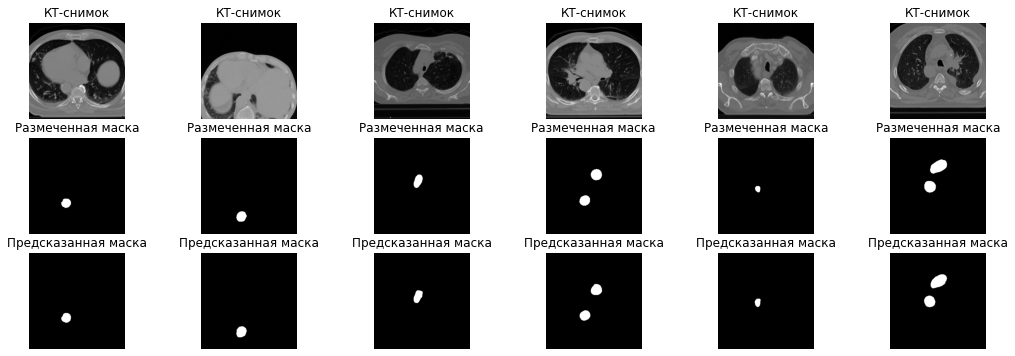

In [28]:
# Visualize tools
clear_output(wait=True)
plt.figure(figsize=(18, 6))
for k in range(6):
    plt.subplot(3, 6, k+1)
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3)[:,:,0], cmap='gray')
    plt.title('КТ-снимок')
    plt.axis('off')

    plt.subplot(3, 6, k+7)
    plt.imshow(Y_val[k, 0].numpy(), cmap='gray')
    plt.title('Размеченная маска')
    plt.axis('off')

    plt.subplot(3, 6, k+13)
    plt.imshow(Y_hat[k, 0].numpy() > 0.5, cmap='gray')
    plt.title('Предсказанная маска')
    plt.axis('off')


plt.show()

# U-Net 2


In [17]:
class DilatedUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
        
        self.pool0 = nn.MaxPool2d(kernel_size=2) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64 

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16 

        # dilated bottleneck
        self.dilated0 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=3, dilation=1, padding=1),
            nn.ReLU()
            )
        self.dilated1 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=512, kernel_size=3, dilation=2, padding=2),
            nn.ReLU()
            )
        self.dilated2 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=512, kernel_size=3, dilation=4, padding=4),
            nn.ReLU()
            )
        self.dilated3 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=512, kernel_size=3, dilation=8, padding=8),
            nn.ReLU()
            )
        self.dilated4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=512, kernel_size=3, dilation=16, padding=16),
            nn.ReLU()
            )
        self.dilated5 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=512, kernel_size=3, dilation=32, padding=32),
            nn.ReLU()
            )


        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(
            in_channels=512, out_channels=512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(
            in_channels=512+256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        
        self.upsample1 = nn.ConvTranspose2d(
            in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(
            in_channels=256+128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        
        self.upsample2 = nn.ConvTranspose2d(
            in_channels=128, out_channels=128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(
            in_channels=128+64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        
        self.upsample3 = nn.ConvTranspose2d(
            in_channels=64, out_channels=64, kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(
            in_channels=64+32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=32, out_channels=1, kernel_size=3, padding=1)
            )



    def forward(self, x):
        # encoder
        e0_0 = self.enc_conv0(x)
        e0 = self.pool0(e0_0)
        e1_0 = self.enc_conv1(e0)
        e1 = self.pool1(e1_0)
        e2_0 = self.enc_conv2(e1)
        e2 = self.pool2(e2_0)
        e3_0 = self.enc_conv3(e2)
        e3 = self.pool3(e3_0)

        # bottleneck
        b0 = self.dilated0(e3)
        b1 = self.dilated1(b0)
        b2 = self.dilated2(b1)
        b3 = self.dilated3(b2)
        b4 = self.dilated4(b3)
        b5 = self.dilated5(b4)
        
        b = b0 + b1 + b2 + b3 + b4 + b5


        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat((d0, e3_0), dim=1)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0)
        d1 = torch.cat((d1, e2_0), dim=1)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        d2 = torch.cat((d2, e1_0), dim=1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2)
        d3 = torch.cat((d3, e0_0), dim=1)
        d3 = self.dec_conv3(d3)

        return d3

In [18]:
dilated_model = DilatedUNet().to(device)
optimaizer = torch.optim.Adam(dilated_model.parameters(), lr=1e-3)
lr_scheduler_exp = lr_scheduler.StepLR(optimaizer, step_size=5, gamma=0.6)

In [19]:
train_loss, val_loss, score = train(dilated_model, optimaizer, lr_scheduler_exp, dice_loss, 20, data_loader_train, data_loader_val, score=True)

* Epoch 1/20


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.54357, Elapsed_time: 384.85273
Current_metric   : 0.137, Current_loss     : 0.53
Best_metric      : 0.137, Best_loss        : 0.53
--------------------------------------------------------------------------------
* Epoch 2/20
Train loss: 0.19515, Elapsed_time: 822.41484
Current_metric   : 0.390, Current_loss     : 0.29
Best_metric      : 0.390, Best_loss        : 0.29
--------------------------------------------------------------------------------
* Epoch 3/20
Train loss: 0.13771, Elapsed_time: 1258.94090
Current_metric   : 0.195, Current_loss     : 0.51
Best_metric      : 0.390, Best_loss        : 0.29
--------------------------------------------------------------------------------
* Epoch 4/20
Train loss: 0.11328, Elapsed_time: 1695.40393
Current_metric   : 0.721, Current_loss     : 0.11
Best_metric      : 0.721, Best_loss        : 0.11
--------------------------------------------------------------------------------
* Epoch 5/20
Train loss: 0.09446, Elapsed_time: 2133.12

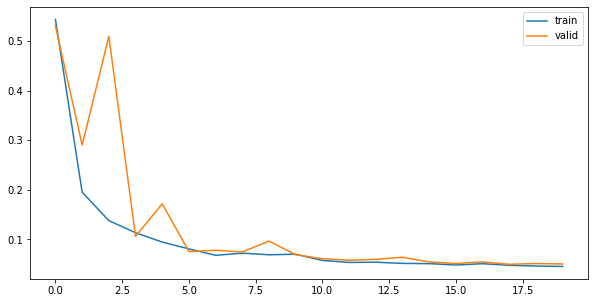

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='valid')
plt.legend()
plt.show()

In [22]:
data = next(iter(data_loader_val))
X_val, Y_val = data['image'], data['mask']
dilated_model.eval()
with torch.no_grad():
    Y_hat = dilated_model(X_val.to(device)).cpu().detach()

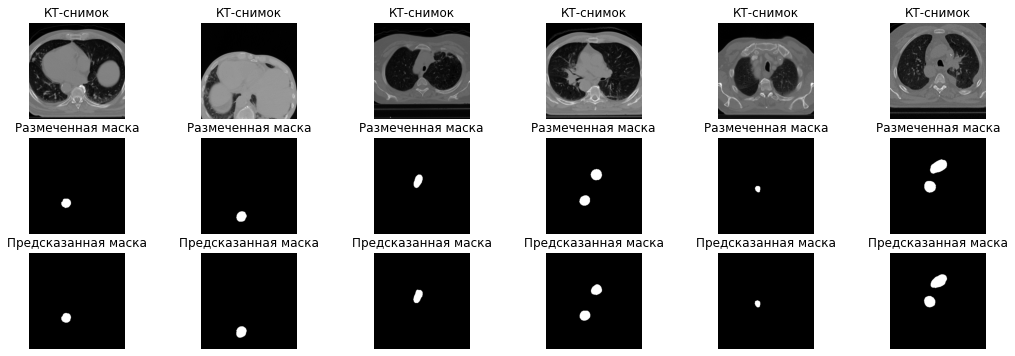

In [23]:
# Visualize tools
clear_output(wait=True)
plt.figure(figsize=(18, 6))
for k in range(6):
    plt.subplot(3, 6, k+1)
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3)[:,:,0], cmap='gray')
    plt.title('КТ-снимок')
    plt.axis('off')

    plt.subplot(3, 6, k+7)
    plt.imshow(Y_val[k, 0].numpy(), cmap='gray')
    plt.title('Размеченная маска')
    plt.axis('off')

    plt.subplot(3, 6, k+13)
    plt.imshow(Y_hat[k, 0].numpy() > 0.5, cmap='gray')
    plt.title('Предсказанная маска')
    plt.axis('off')


plt.show()